In [1]:
# --- 1. Librerie ---------------------------------------------
from pathlib import Path, PurePosixPath
import os
import re, json, functools
from PIL import Image
from io import BytesIO
import ipywidgets as widgets
from IPython.display import HTML, display
import uuid, ipywidgets as widgets

import matplotlib.pyplot as plt
import matplotlib.animation as anim
import ipywidgets as w

import pandas as pd
from datetime import datetime, timedelta


In [2]:
lista_nuove_date = []

In [3]:
# --- 2. Raccolgo l’elenco dei frame --------------------------

id = "Juliette"  # ID del ciclone
frames_dir = Path(f"./anim_frames_{id}")
paths = sorted(Path(frames_dir).glob("*.png"), key=lambda p: int(re.search(r"\d+", p.stem).group()))
n = len(paths)  
print(f"Carico i frame da {frames_dir} ({n} frame)")

#video_path = "ciclone7001358.mp4" 

Carico i frame da anim_frames_Juliette (1306 frame)




# 1) raccogli e ordina i file numericamente (frame_0001.png …)
frames = sorted(Path(frames_dir).glob("*.png"),
                key=lambda p: int(re.search(r"\d+", p.stem).group()))
n  = len(frames)
fnames = [p.name for p in frames]          # solo il nome, ci serve in JS

# 2) animazione con FuncAnimation: carica il PNG solo quando serve
fig, ax = plt.subplots(figsize=(6,4))
ax.axis("off")
img_plot = ax.imshow(plt.imread(frames[0]))      # primo frame

def update(i):
    img_plot.set_data(plt.imread(frames[i]))
    return (img_plot,)

ani = anim.FuncAnimation(fig, update, frames=n, interval=33, blit=True)

# 3) widget Python che riceveranno i due nomi file
t_in  = w.Text(description="INIZIO", disabled=True)
t_out = w.Text(description="FINE",   disabled=True)

# 4) HTML del player + due pulsanti legati al widget-manager
uid = f"anim_{uuid.uuid4().hex[:6]}"
player_html = ani.to_jshtml().replace(
    '<div class="animation"', f'<div id="{uid}" class="animation"')

extra_js = f"""
<script>
(function wait(cb){{                 // aspetta che require() sia pronto
  (typeof require!=="undefined") ? cb() : setTimeout(()=>wait(cb),50);
}})(function(){{
  require(["@jupyter-widgets/base"], function(w){{
    const mgr = [...w.ManagerBase._managers][0];
    const root = document.getElementById("{uid}");
    const slider = root.querySelector('input[type=range]');
    const files = {json.dumps(fnames)};

    root.insertAdjacentHTML('beforeend',
      '<br><button id="btnIn">Segna INIZIO</button> '+
      '<button id="btnOut">Segna FINE</button>');

    const setVal = (btnId, modelId) => {{
      root.querySelector(btnId).onclick = () => {{
        const idx = parseInt(slider.value, 10);
        mgr.get_model(modelId).then(m => {{
          m.set("value", files[idx]);
          m.save_changes();
          console.log(btnId.slice(-3), files[idx]);   // log visivo
        }});
      }};
    }};
    setVal("#btnIn",  "{t_in.model_id}");
    setVal("#btnOut", "{t_out.model_id}");
  }});
}});
</script>
"""

display(HTML(player_html + extra_js))
display(t_in, t_out)
plt.close(fig)           # evita la doppia figura statica


In [4]:
# ---------------------------------------------------------------
# 3) cache in RAM dei frame ridotti (lru_cache)
# ---------------------------------------------------------------
@functools.lru_cache(maxsize=512)           # 512 frame ≃ 40-50 MB
def load_jpeg(idx, max_side=720, quality=80):
    img = Image.open(paths[idx])
    img.thumbnail((max_side, max_side), Image.Resampling.LANCZOS)
    if img.mode not in ("RGB", "L"):
        img = img.convert("RGB")
    buf = BytesIO()
    img.save(buf, format="JPEG", quality=quality)
    return buf.getvalue()

# ---------------------------------------------------------------
# 4) widget: Play ⇄ Slider + Image + pulsanti IN/OUT
# ---------------------------------------------------------------
play   = w.Play(value=0, min=0, max=n-1, step=1, interval=40)  # 25 fps
slider = w.IntSlider(value=0, min=0, max=n-1, step=1,
                     readout=False, layout=w.Layout(width='70%'))
w.jslink((play, 'value'), (slider, 'value'))

img_box = w.Image(format='jpeg')
log     = w.Output(layout={'border':'1px solid lightgray', 'max_height':'120px',
                           'overflow_y':'auto'})

btn_in  = w.Button(description="Segna INIZIO", button_style='success')
btn_out = w.Button(description="Segna FINE",   button_style='info')

start = w.Text(description='INIZIO', disabled=True)
end   = w.Text(description='FINE',   disabled=True)

# ---------------------------------------------------------------
# 5) callback per mostrare il frame e per i pulsanti
# ---------------------------------------------------------------
def show(idx):
    img_box.value = load_jpeg(idx)

slider.observe(lambda c: show(c['new']), names='value')
show(0)                       # visualizza il primo

def make_handler(target):
    def handler(_):
        idx = slider.value
        fname = paths[idx].name
        target.value = fname
        with log:
            print(f"{fname}")
    return handler

btn_in.on_click(make_handler(start))
btn_out.on_click(make_handler(end))

# ---------------------------------------------------------------
# 6) layout e display
# ---------------------------------------------------------------
ui = w.VBox([
        w.HBox([play, slider]),
        img_box,
        w.HBox([btn_in, btn_out]),
        w.HBox([start, end]),
        log,
])
display(ui)


In [128]:
start.value, end.value

('frame_1087.png', 'frame_1692.png')

Visualizzo i frame anim_frames_Juliette/frame_0288.png e anim_frames_Juliette/frame_1084.png


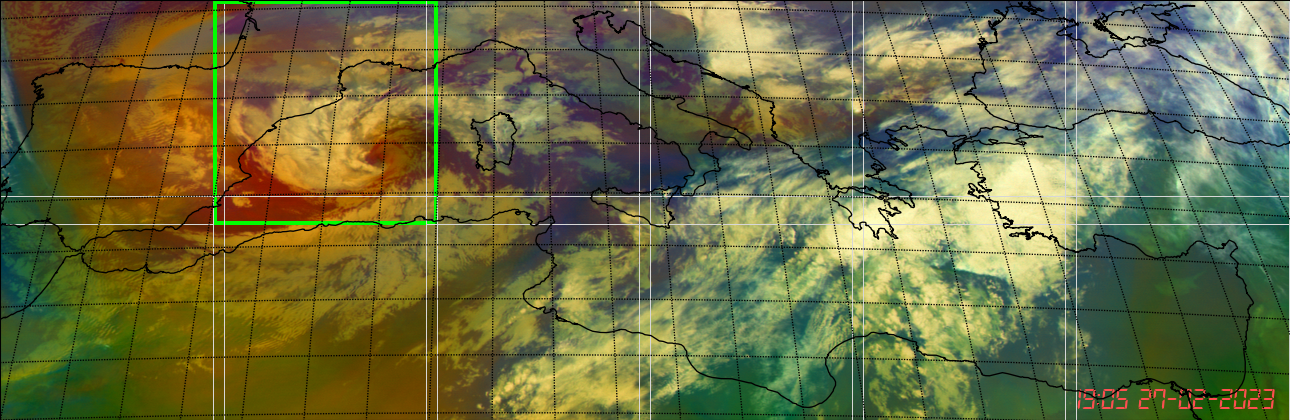

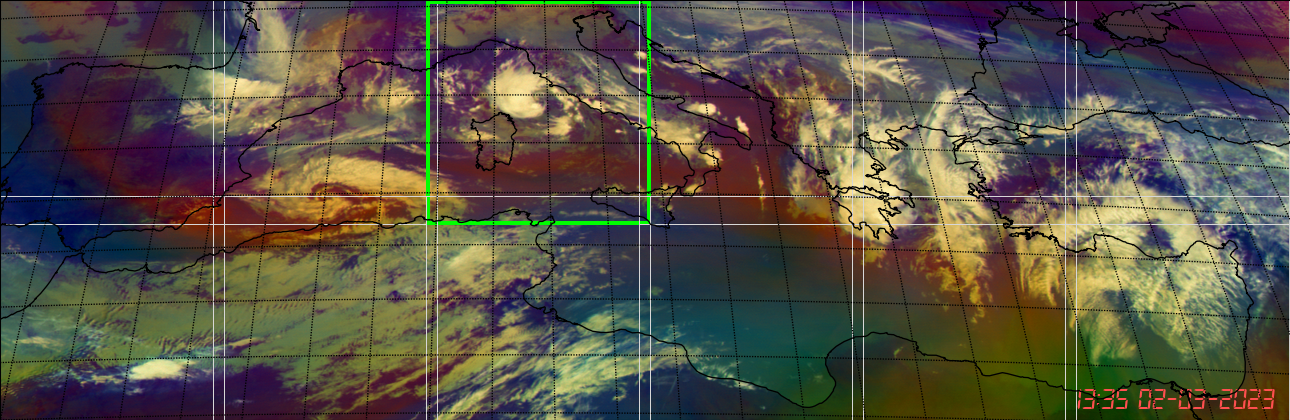

In [144]:
if start.value == end.value:
    print("Inizio e fine sono uguali")
if not start.value or not end.value:
    print("Inizio o fine non sono stati selezionati.")

# check if file exists
start_frame = frames_dir / start.value
if not os.path.exists(start_frame):
    print(f"Il file {start.value} non esiste nella cartella {frames_dir}")
# check for end frame
end_frame = frames_dir / end.value
if not os.path.exists(end_frame):
    print(f"Il file {end.value} non esiste nella cartella {frames_dir}")

# display the selected frames here in jupyter with pillow
print(f"Visualizzo i frame {start_frame} e {end_frame}")
img = Image.open(start_frame)
display(img)
img = Image.open(end_frame)
display(img)


In [145]:
new_start = pd.to_datetime(datetime(2023,2,27,19,0))
new_end = pd.to_datetime(datetime(2023,3,2,13,30))
new_limits = {'name': id, 'new_start': new_start, 'new_end': new_end}
lista_nuove_date.append(new_limits)


In [146]:
df_new_limits = pd.DataFrame(lista_nuove_date)
df_new_limits

,id,new_start,new_end,name
0,7001358,2012-04-13 04:15:00,2012-04-14 21:00:00,NaN
1,7001421,2013-11-18 22:00:00,2013-11-20 09:00:00,NaN
2,7001500,2015-09-30 21:25:00,2015-10-01 21:00:00,NaN
3,7001466,2014-11-30 06:25:00,2014-12-03 06:30:00,NaN
4,7001521,2016-02-28 23:20:00,2016-03-01 08:05:00,NaN
5,7001715,2020-12-13 08:20:00,2020-12-16 13:45:00,NaN
6,7001674,2019-11-10 09:30:00,2019-11-11 17:30:00,NaN
7,7001716,2020-12-25 10:35:00,2020-12-27 10:50:00,NaN
8,7001702,2020-09-14 23:50:00,2020-09-18 19:40:00,NaN
9,7001575,2017-11-16 14:45:00,2017-11-18 12:40:00,NaN


In [147]:
df_new_limits.to_csv('new_cyc_limits.csv', index=False)

from ipywidgets import Video, Button, FloatText, VBox, HBox
from IPython.display import display

# --- video -----------------------------------------------------
v = Video.from_file(video_path)     # autoplay=False, controls=True di default

# --- campi inizio/fine ----------------------------------------
t_start = FloatText(description='INIZIO', disabled=True)
t_end   = FloatText(description='FINE',   disabled=True)

# --- pulsanti --------------------------------------------------
b_start = Button(description='Segna INIZIO', button_style='success')
b_end   = Button(description='Segna FINE',   button_style='info')

# Nota: su ipywidgets ≥8  il tempo corrente è v.current_time
def mark_start(_): t_start.value = v.current_time
def mark_end(_):   t_end.value   = v.current_time

b_start.on_click(mark_start)
b_end.on_click(mark_end)

display(VBox([v, HBox([b_start, b_end]), t_start, t_end]))


In [2]:
abs_path   = Path(video_path).resolve() # /media/isacDisk1/VideoMAEv2/ciclone7001358.mp4
server_root = Path(os.environ.get("PWD", ".")).resolve()   # dove hai lanciato Jupyter
rel_path   = abs_path.relative_to(server_root)             # media/isacDisk1/VideoMAEv2/...
src_url    = f"/files/{PurePosixPath(rel_path).as_posix()}"  # /files/media/...

print("DEBUG — URL al browser:", src_url)    # verifica

DEBUG — URL al browser: /files/VideoMAEv2/ciclone7001358.mp4


import ipywidgets as widgets, uuid
from pathlib import PurePosixPath
from IPython.display import display, HTML


# -----------------------------------------------------------------
# 2) Widget Python che conterranno i timestamp
# -----------------------------------------------------------------
t_start = widgets.FloatText(description="INIZIO", disabled=True)
t_end   = widgets.FloatText(description="FINE",   disabled=True)

# -----------------------------------------------------------------
# 3) Genera ID univoci per i nodi HTML/JS
# -----------------------------------------------------------------
#vid_id = f"vid_{uuid.uuid4().hex[:8]}"
#b1_id  = f"b1_{uuid.uuid4().hex[:6]}"
#b2_id  = f"b2_{uuid.uuid4().hex[:6]}"

vid_id, b1_id, b2_id = [f"{p}_{uuid.uuid4().hex[:6]}" for p in ("vid","b1","b2")]

import uuid, ipywidgets as widgets
from pathlib import PurePosixPath
from IPython.display import display, HTML



# 2️⃣  widget Python che riceveranno i timestamp
t_start = widgets.FloatText(description="INIZIO", disabled=True)
t_end   = widgets.FloatText(description="FINE",   disabled=True)

# 3️⃣  ID HTML univoci
vid_id, b1_id, b2_id = [f"{prefix}_{uuid.uuid4().hex[:6]}" 
                        for prefix in ("vid", "b1", "b2")]

# 4️⃣  HTML + ponte JS  (NB: le {{ }} rimangono graffe nel codice JS)
html = f"""
<div style="max-width:720px">
  <video id="{vid_id}" width="100%" controls src="{src_url}"></video><br>
  <button id="{b1_id}" style="margin-top:6px">Segna INIZIO</button>
  <button id="{b2_id}">Segna FINE</button>
</div>

<script>
require.config({{paths: {{widgets: '@jupyter-widgets/base'}}}});
require(["widgets"], function(widgets) {{
    const vid = document.getElementById("{vid_id}");
    const getMgr = () => [...widgets.ManagerBase._managers][0] || null;

    document.getElementById("{b1_id}").onclick = () => {{
        const mgr = getMgr();
        if (!mgr) return console.warn("manager non pronto");
        mgr.get_model("{t_start.model_id}").then(m => {{
            m.set("value", vid.currentTime);
            m.save_changes();
        }});
    }};

    document.getElementById("{b2_id}").onclick = () => {{
        const mgr = getMgr();
        if (!mgr) return console.warn("manager non pronto");
        mgr.get_model("{t_end.model_id}").then(m => {{
            m.set("value", vid.currentTime);
            m.save_changes();
        }});
    }};
}});
</script>
"""

# 5️⃣  Mostra player e campi INIZIO/FINE
display(HTML(html))
display(t_start)
display(t_end)


In [5]:
# ── widget Python che terranno i timestamp ─────────────────────
t_in  = widgets.FloatText(description="INIZIO", disabled=True)
t_out = widgets.FloatText(description="FINE",   disabled=True)

# ── ID HTML univoci ────────────────────────────────────────────
vid_id, b1_id, b2_id = [f"{p}_{uuid.uuid4().hex[:6]}" for p in ("vid","b1","b2")]

# ── HTML + ponte JavaScript (importa da jsdelivr, suffisso +esm) ─
html = f"""
<video id="{vid_id}" width="720" controls src="{src_url}"></video><br>
<button id="{b1_id}">Segna INIZIO</button>
<button id="{b2_id}">Segna FINE</button>

<script type="module">
import {{ ManagerBase }} from "https://cdn.jsdelivr.net/npm/@jupyter-widgets/base@5/+esm";

const vid   = document.getElementById("{vid_id}");
const btnIn = document.getElementById("{b1_id}");
const btnOut= document.getElementById("{b2_id}");

/* attende finché il widget-manager è pronto */
const waitMgr = async () => {{
  while ([...ManagerBase._managers].length === 0) {{
    await new Promise(r => setTimeout(r, 40));
  }}
  return [...ManagerBase._managers][0];
}};

waitMgr().then(mgr => {{
  console.log("manager ok");
  btnIn.onclick  = () => mgr.get_model("{t_in.model_id}").then(m => {{
      m.set('value', vid.currentTime); m.save_changes();
  }});
  btnOut.onclick = () => mgr.get_model("{t_out.model_id}").then(m => {{
      m.set('value', vid.currentTime); m.save_changes();
  }});
}});
</script>
"""

display(HTML(html))
display(t_in, t_out)


FloatText(value=0.0, description='INIZIO', disabled=True)

FloatText(value=0.0, description='FINE', disabled=True)

In [6]:
print(t_start.value, t_end.value)


0.0 0.0
